# Section 5: Cleaning, Processing, Analysis



# Dependencies

Datasets used:
*   unique_research_outputs.csv (Part 3)
*   Researchers 2024 (Git)

Dependencies listed below:

In [ ]:
# !pip install bertopic

In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import networkx as nx
import requests
from io import BytesIO
import re
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords
import string
import statsmodels.formula.api as smf # for multiple regression
import umap # for bert
import hdbscan # for bert
import unittest

# Defining Functions

In [3]:
def load_data(filename):
  """
    Load data from a CSV file using pandas
    Args:
    filename: Enter filename as str (include quotations)
  """
  try:
    df = pd.read_csv(filename)
    return df
  except FileNotFoundError: # important to add to deal with path errors
    print("File not found. Check file path.")
  except csv.Error as e: # csv related errors
    print(f"CSV error: {e}")
  except Exception as e: # all other errors
    print(f"An unexpected error occurred: {e}")


def load_data_from_url(url):
    """
    Loads csv/xlsx data from a URL using pandas, requests, and BytesIO
    Args:
    filename: Enter filename as str (include quotations)
    """
    # Ensure we're using the raw file URL
    if "blob" in url:
        url = url.replace("blob/", "raw/")
    # Download the file
    response = requests.get(url)
    if response.status_code == 200: # if successfully dowloaded
        content = BytesIO(response.content)
        file_extension = url.split('.')[-1].lower() # extract extensions
        # Read file based on extension
        if file_extension in ['xls', 'xlsx']: # if xls
            return pd.read_excel(content, engine="openpyxl" if file_extension == "xlsx" else "xlrd") # use read_excel
        elif file_extension == 'csv': # if csv
            return pd.read_csv(content)
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")
    else:
        raise ValueError(f"Failed to download the file. Status code: {response.status_code}")


# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_text(text):
    """
    Cleans text by removing stopwords and punctuation
    Args:
    filename: enter text as str (include quotations)
    """
    words = text.split()
    return ' '.join(word for word in words if word.lower() not in stop_words and word not in punctuation)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Ingestion and Processing

In [4]:
# unique data from API
df=load_data('unique_research_outputs.csv')
# unique data from webscraping
df_webscraping =load_data('unique_outputs_webscraping.csv')
# 2024 data compiled earlier
data_24 =load_data_from_url("https://github.com/dingkaihua/fsrdc-external-census-projects/blob/master/ResearchOutputs.xlsx")

In [5]:
# checking missing values
print(df.isnull().sum())

title                      4
doi                      445
abstract                   0
year                       0
publication_date           0
cited_by_count             0
authors                    0
affiliations             443
topics                    10
source_display_name      268
type_crossref              0
researcher                 0
author_id                  0
queried_dataset_terms      0
matched_dataset_terms      0
location                   0
dtype: int64


In [6]:
# checking missing values
print(df_webscraping.isnull().sum())

title                         0
doi                           5
abstract                      0
year                          0
publication_date              5
cited_by_count                5
authors                       0
affiliations                 53
topics                        5
source_display_name          53
type_crossref                 5
researcher                    0
matched_dataset_terms        40
mention_restricted_data       0
mention_disclosure_review     0
mention_rdc                   0
dtype: int64


In [7]:
# checking missing values in 2024 dataset
print(data_24.isnull().sum())

ProjectID              0
ProjectStatus          0
ProjectTitle           0
ProjectRDC             0
ProjectStartYear       0
ProjectEndYear       380
ProjectPI              0
OutputTitle            1
OutputBiblio           0
OutputType             0
OutputStatus           1
OutputVenue          247
OutputYear             4
OutputMonth         1382
OutputVolume        1273
OutputNumber         893
OutputPages         1348
dtype: int64


In [8]:
if len(data_24) == 1735:
    print(f"Validation passed: The dataset contains {len(data_24)} rows.")
else:
    print(f"Validation failed: The dataset contains {len(data_24)} rows, expected 1735.")

Validation passed: The dataset contains 1735 rows.


In [9]:
df.head(n=3)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,author_id,queried_dataset_terms,matched_dataset_terms,location
0,The Bridge between the LexisNexis Directory of...,NaN,The purpose of this matching exercise is to co...,2015,2015-01-01,0,"{'Aaron Flaaen', 'Yue Maggie Zhou'}",NaN,Cooperative Studies and Economics,NaN,article,Aaron B Flaaen,https://openalex.org/A5081886594,Survey of Plant Capacity Utilization; Foreign ...,Census Bureau,Michigan
1,Vulnerable Jobs and the Wage Effects of Import...,https://doi.org/10.1111/irel.12240,Do job characteristics modulate the relationsh...,2019,2019-06-10,1,"{'David L. Rigby', 'Thomas Kemeny', 'Abigail M...","University at Buffalo, State University of New...",Employment and Welfare Studies; Labor market d...,Industrial Relations A Journal of Economy and ...,article,Abigail M Cooke,https://openalex.org/A5072101814,LEHD Geocoded Address List (GAL) - 2008; Curre...,Census Bureau,Triangle
2,Impacts of Trade on Wage Inequality across the...,NaN,The research presented in this dissertation ex...,2014,2014-01-01,0,{'Abigail M. Cooke'},NaN,Regional Economic and Spatial Analysis,NaN,article,Abigail M Cooke,https://openalex.org/A5072101814,LEHD Geocoded Address List (GAL) - 2008; Curre...,Census Bureau,Triangle


In [10]:
df_webscraping.head(n=3)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,matched_dataset_terms,mention_restricted_data,mention_disclosure_review,mention_rdc
0,The Intangible Divide: Why Do So Few Firms Inv...,https://doi.org/10.2139/ssrn.4988419,"Investments in software, R&D, and advertising ...",2025,2024-01-01,0.0,"{'Xiupeng Wang', 'James Bessen'}",NaN,Business; Industrial organization; Commerce,NaN,article,James Bessen,NaN,True,False,False
1,Corporate Share Repurchase Policies and Labor ...,https://doi.org/10.2139/ssrn.5066681,"Using census data, we investigate whether shar...",2025,2024-01-01,0.0,"{'Darren Kisgen', 'Lei Kong', 'Xudong Fu'}",NaN,Business; Share repurchase; Labour economics; ...,NaN,preprint,Xudong Fu,NaN,True,False,False
2,The Effect of Oil News Shocks on Job Creation ...,https://doi.org/10.1016/s0140-6736(17)32345-0,Using data from the Annual Survey of Manufactu...,2025,2017-10-20,4145.0,"{'Ryan Hanson', 'Ana María Herrera'}",NaN,Environmental health; Pollution; Commission; E...,NaN,review,Ryan Hanson,annual survey of manufactures,True,False,False


In [11]:
data_24.head(n=3)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,OutputStatus,OutputVenue,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages
0,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,"Entry, Expansion, and Intensity in the U.S. Ex...","Bernard, A.B. and Jensen, J.B. (2004), Entry, ...",JA,PB,Review of International Economics,2004.0,NaN,12,4,662-675
1,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,Product Choice and Product Switching,"Bernard, Andrew B., Stephen Redding and Peter ...",WP,PB,NBER,2003.0,NaN,NaN,9789,NaN
2,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,Plants and Productivity in International Trade,"Bernard, Andrew, B., Jonathan Eaton, J. Bradfo...",JA,PB,American Economic Review,2003.0,NaN,93,4,1268-1290


In [12]:
# checking structure of all datasets
column_names_list = df.columns.to_list()
print(column_names_list)

['title', 'doi', 'abstract', 'year', 'publication_date', 'cited_by_count', 'authors', 'affiliations', 'topics', 'source_display_name', 'type_crossref', 'researcher', 'author_id', 'queried_dataset_terms', 'matched_dataset_terms', 'location']


In [13]:
# checking structure of all datasets
column_names_list = df_webscraping.columns.to_list()
print(column_names_list) # missing col names such as location etc

['title', 'doi', 'abstract', 'year', 'publication_date', 'cited_by_count', 'authors', 'affiliations', 'topics', 'source_display_name', 'type_crossref', 'researcher', 'matched_dataset_terms', 'mention_restricted_data', 'mention_disclosure_review', 'mention_rdc']


In [14]:
# checking structure of all 2024 datasets
column_names_list = data_24.columns.to_list()
print(column_names_list)

['ProjectID', 'ProjectStatus', 'ProjectTitle', 'ProjectRDC', 'ProjectStartYear', 'ProjectEndYear', 'ProjectPI', 'OutputTitle', 'OutputBiblio', 'OutputType', 'OutputStatus', 'OutputVenue', 'OutputYear', 'OutputMonth', 'OutputVolume', 'OutputNumber', 'OutputPages']


In [15]:
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows in unique dataset: {duplicate_count}")

Number of duplicate rows in unique dataset: 1


In [16]:
# dropping duplicates
df = df.drop_duplicates()

In [17]:
duplicate_count = df_webscraping.duplicated().sum()
print(f"Number of duplicate rows in unique dataset: {duplicate_count}")

Number of duplicate rows in unique dataset: 0


In [18]:
df.head(n=4)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,author_id,queried_dataset_terms,matched_dataset_terms,location
0,The Bridge between the LexisNexis Directory of...,NaN,The purpose of this matching exercise is to co...,2015,2015-01-01,0,"{'Aaron Flaaen', 'Yue Maggie Zhou'}",NaN,Cooperative Studies and Economics,NaN,article,Aaron B Flaaen,https://openalex.org/A5081886594,Survey of Plant Capacity Utilization; Foreign ...,Census Bureau,Michigan
1,Vulnerable Jobs and the Wage Effects of Import...,https://doi.org/10.1111/irel.12240,Do job characteristics modulate the relationsh...,2019,2019-06-10,1,"{'David L. Rigby', 'Thomas Kemeny', 'Abigail M...","University at Buffalo, State University of New...",Employment and Welfare Studies; Labor market d...,Industrial Relations A Journal of Economy and ...,article,Abigail M Cooke,https://openalex.org/A5072101814,LEHD Geocoded Address List (GAL) - 2008; Curre...,Census Bureau,Triangle
2,Impacts of Trade on Wage Inequality across the...,NaN,The research presented in this dissertation ex...,2014,2014-01-01,0,{'Abigail M. Cooke'},NaN,Regional Economic and Spatial Analysis,NaN,article,Abigail M Cooke,https://openalex.org/A5072101814,LEHD Geocoded Address List (GAL) - 2008; Curre...,Census Bureau,Triangle
3,Impacts of Trade on Wage Inequality across the...,NaN,"Author(s): Cooke, Abigail Montague | Advisor(s...",2014,2014-01-01,0,{'Abigail M. Cooke'},NaN,Global trade and economics; Regional Economic ...,NaN,article,Abigail M Cooke,https://openalex.org/A5072101814,LEHD Geocoded Address List (GAL) - 2008; Curre...,Census Bureau,Triangle


In [19]:
# exploring duplicates:
df[df.duplicated(subset=['title', 'publication_date', 'authors',	'topics',	'source_display_name', 'abstract','location', 'type_crossref'])].sort_values(by=['title', 'publication_date']).head(n=5)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,author_id,queried_dataset_terms,matched_dataset_terms,location
1116,201 -Accessing Business Data Available in the ...,NaN,"Javier Miranda, Census Research Data Center Ne...",2011,2011-01-27,0,"{'James C. Davis', 'Shawn D. Klimek', 'Randy A...",NaN,Spatial and Panel Data Analysis; Census and Po...,NaN,article,Randy A Becker,https://openalex.org/A5065233144,Survey of Plant Capacity Utilization; Manufact...,Census Bureau,Boston
147,A Comparative Efficiency Analysis of Cooperati...,NaN,Due to differences in ownership structure betw...,2013,2013-01-01,1,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",NaN,Efficiency Analysis Using DEA; Cooperative Stu...,RePEc: Research Papers in Economics,preprint,Christopher A Kanter,https://openalex.org/A5028682170,Census Bureau; Census of Services; Wisconsin R...,Census of Manufactures,Wisconsin
148,A Comparative Efficiency Analysis of Cooperati...,https://doi.org/10.22004/ag.econ.150497,Due to differences in ownership structure betw...,2013,2013-01-01,0,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",University of Wisconsin–Madison; University of...,Efficiency Analysis Using DEA; Cooperative Stu...,"2013 Annual Meeting, August 4-6, 2013, Washing...",article,Christopher A Kanter,https://openalex.org/A5028682170,Census Bureau; Census of Services; Wisconsin R...,Census of Manufactures,Wisconsin
1262,A Method for Measuring Coupled Individual and ...,https://doi.org/10.1080/24694452.2021.1989283,Although models of social vulnerability to env...,2022,2022-01-24,18,"{'Seth Spielman', 'Joseph Tuccillo'}",National Geospatial-Intelligence Agency; Oak R...,Disaster Management and Resilience; Flood Risk...,Annals of the American Association of Geographers,article,Seth E Spielman,https://openalex.org/A5078177514,FSRDC; Colorado RDC; Decennial Census; Census ...,Census Bureau,Colorado
203,A New Infrastructure for Monitoring Social Mob...,https://doi.org/10.1177/0002716214549941,The country's capacity to monitor trends in so...,2014,2014-12-10,39,"{'Timothy M. Smeeding', 'C. Matthew Snipp', 'D...",NaN,"Urban, Neighborhood, and Segregation Studies; ...",The Annals of the American Academy of Politica...,article,David B Grusky,https://openalex.org/A5043962579,BOC PIK Crosswalk American Community Survey (A...,Decennial Census,Stanford


In [20]:
# sample duplicate output
df[df["title"] == "A Comparative Efficiency Analysis of Cooperative and Non-cooperative Dairy Manufacturing Firms"]

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,author_id,queried_dataset_terms,matched_dataset_terms,location
102,A Comparative Efficiency Analysis of Cooperati...,NaN,Due to differences in ownership structure betw...,2013,2013-01-01,1,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",NaN,Efficiency Analysis Using DEA; Cooperative Stu...,RePEc: Research Papers in Economics,preprint,Brent M Hueth,https://openalex.org/A5068895177,Census of Manufactures; Integrated Longitudina...,Census of Manufactures,Wisconsin
103,A Comparative Efficiency Analysis of Cooperati...,https://doi.org/10.22004/ag.econ.150497,Due to differences in ownership structure betw...,2013,2013-01-01,0,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",University of Wisconsin–Madison; University of...,Efficiency Analysis Using DEA; Cooperative Stu...,"2013 Annual Meeting, August 4-6, 2013, Washing...",article,Brent M Hueth,https://openalex.org/A5068895177,Census of Manufactures; Integrated Longitudina...,Census of Manufactures,Wisconsin
118,A Comparative Efficiency Analysis of Cooperati...,NaN,Due to differences in ownership structure betw...,2013,2013-01-01,1,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",NaN,Efficiency Analysis Using DEA; Cooperative Stu...,RePEc: Research Papers in Economics,preprint,Brian W Gould,https://openalex.org/A5112034435,Chicago RDC; Census of Manufactures; Annual Su...,Census of Manufactures,Chicago
119,A Comparative Efficiency Analysis of Cooperati...,https://doi.org/10.22004/ag.econ.150497,Due to differences in ownership structure betw...,2013,2013-01-01,0,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",University of Wisconsin–Madison; University of...,Efficiency Analysis Using DEA; Cooperative Stu...,"2013 Annual Meeting, August 4-6, 2013, Washing...",article,Brian W Gould,https://openalex.org/A5112034435,Chicago RDC; Census of Manufactures; Annual Su...,Census of Manufactures,Chicago
147,A Comparative Efficiency Analysis of Cooperati...,NaN,Due to differences in ownership structure betw...,2013,2013-01-01,1,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",NaN,Efficiency Analysis Using DEA; Cooperative Stu...,RePEc: Research Papers in Economics,preprint,Christopher A Kanter,https://openalex.org/A5028682170,Census Bureau; Census of Services; Wisconsin R...,Census of Manufactures,Wisconsin
148,A Comparative Efficiency Analysis of Cooperati...,https://doi.org/10.22004/ag.econ.150497,Due to differences in ownership structure betw...,2013,2013-01-01,0,"{'Brent Hueth', 'Brian W. Gould', 'Christopher...",University of Wisconsin–Madison; University of...,Efficiency Analysis Using DEA; Cooperative Stu...,"2013 Annual Meeting, August 4-6, 2013, Washing...",article,Christopher A Kanter,https://openalex.org/A5028682170,Census Bureau; Census of Services; Wisconsin R...,Census of Manufactures,Wisconsin


In [21]:
# drop duplicates across all cols i.e. 1 will be dropped
df = df.drop_duplicates()
df.shape

(1390, 16)

In [22]:
# drop duplicates across subset cols i.e. 285 will be dropped
df = df.drop_duplicates(subset=['title', 'publication_date', 'abstract','authors','source_display_name',	'topics',	'location', 'type_crossref'])
df.shape

(1105, 16)

In [23]:
df_webscraping.head(n=2)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,matched_dataset_terms,mention_restricted_data,mention_disclosure_review,mention_rdc
0,The Intangible Divide: Why Do So Few Firms Inv...,https://doi.org/10.2139/ssrn.4988419,"Investments in software, R&D, and advertising ...",2025,2024-01-01,0.0,"{'Xiupeng Wang', 'James Bessen'}",NaN,Business; Industrial organization; Commerce,NaN,article,James Bessen,NaN,True,False,False
1,Corporate Share Repurchase Policies and Labor ...,https://doi.org/10.2139/ssrn.5066681,"Using census data, we investigate whether shar...",2025,2024-01-01,0.0,"{'Darren Kisgen', 'Lei Kong', 'Xudong Fu'}",NaN,Business; Share repurchase; Labour economics; ...,NaN,preprint,Xudong Fu,NaN,True,False,False


In [24]:
# no duplicates based on selected col in webscraped data:
df_webscraping[df_webscraping.duplicated(subset=['title', 'publication_date', 'authors',	'topics', 'abstract','type_crossref'])].sort_values(by=['title', 'publication_date']).head(n=2)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,matched_dataset_terms,mention_restricted_data,mention_disclosure_review,mention_rdc


In [25]:
# Check for duplicate rows based on all columns
duplicate_count = data_24.duplicated().sum()
print(f"Number of duplicate rows in 2024 dataset: {duplicate_count}")

Number of duplicate rows in 2024 dataset: 0


In [26]:
data_24.head(n=3)

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,OutputStatus,OutputVenue,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages
0,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,"Entry, Expansion, and Intensity in the U.S. Ex...","Bernard, A.B. and Jensen, J.B. (2004), Entry, ...",JA,PB,Review of International Economics,2004.0,NaN,12,4,662-675
1,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,Product Choice and Product Switching,"Bernard, Andrew B., Stephen Redding and Peter ...",WP,PB,NBER,2003.0,NaN,NaN,9789,NaN
2,5,Completed,The Impact of Foreign Trade on the U.S. Economy,Boston,2001,2004.0,J Bradford Jensen,Plants and Productivity in International Trade,"Bernard, Andrew, B., Jonathan Eaton, J. Bradfo...",JA,PB,American Economic Review,2003.0,NaN,93,4,1268-1290


In [27]:
# Check for duplicate rows based on selected columns
duplicate_count = data_24.duplicated(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','ProjectPI', 'OutputYear']).sum()
print(f"Number of duplicate rows in 2024 dataset: {duplicate_count}")

Number of duplicate rows in 2024 dataset: 1


In [28]:
# inspecting
data_24[data_24.duplicated(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','ProjectPI', 'OutputYear'])]

,ProjectID,ProjectStatus,ProjectTitle,ProjectRDC,ProjectStartYear,ProjectEndYear,ProjectPI,OutputTitle,OutputBiblio,OutputType,OutputStatus,OutputVenue,OutputYear,OutputMonth,OutputVolume,OutputNumber,OutputPages
1499,1975,Active,Firm Organization Across Space,Boston,2019,NaN,Teresa C Fort,Industry Linkages from Joint Production,"Xiang Ding, 2023. ""Industry Linkages from Join...",WP,PB,Center for Economic Studies,2023.0,NaN,NaN,NaN,NaN


In [29]:
# drop duplicates across subset cols
data_24 = data_24.drop_duplicates(subset=['OutputTitle', 'OutputType',	'ProjectRDC',	'OutputVenue','ProjectPI', 'OutputYear'])
data_24.shape

(1734, 17)

# Cleaning

## API Dataset

In [30]:
# creating subset of unique scraped dataset
df_subset = df.loc[:,["title", "year", "publication_date", "authors","abstract", "topics", "type_crossref",
 "location", "cited_by_count"]]




In [31]:
# Renaming variables in unique scraped dataset:
df_subset = df_subset.rename(columns={"title": "OutputTitle", "year": "OutputYear",
                                            "publication_date": "PublicationDate",
                                            "authors": "ProjectPI", "topics": "Keywords", "type_crossref": "OutputType",
                                            "location": "ProjectRDC", "abstract" : "Abstract",
                                            "cited_by_count": "CiteCount" })

In [32]:
df_subset.head(n=3)

,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount
0,The Bridge between the LexisNexis Directory of...,2015,2015-01-01,"{'Aaron Flaaen', 'Yue Maggie Zhou'}",The purpose of this matching exercise is to co...,Cooperative Studies and Economics,article,Michigan,0
1,Vulnerable Jobs and the Wage Effects of Import...,2019,2019-06-10,"{'David L. Rigby', 'Thomas Kemeny', 'Abigail M...",Do job characteristics modulate the relationsh...,Employment and Welfare Studies; Labor market d...,article,Triangle,1
2,Impacts of Trade on Wage Inequality across the...,2014,2014-01-01,{'Abigail M. Cooke'},The research presented in this dissertation ex...,Regional Economic and Spatial Analysis,article,Triangle,0


In [33]:
# cleaning ProjectPI: removing quotes
df_subset['ProjectPI'] = df_subset['ProjectPI'].apply(lambda x: set(name.strip("'\"") for name in ast.literal_eval(x)))

In [34]:
# count of authors
max_length = df_subset['ProjectPI'].apply(len).max()
print("Maximum set length:", max_length)

Maximum set length: 48


In [35]:
# clean authors storing each author separately
for i in range(48):
    col_name = f'Author_{i+1}'
    df_subset[col_name] = df_subset['ProjectPI'].apply(
        lambda x: sorted(x)[i] if isinstance(x, set) and len(x) > i else None
    )

In [36]:
df_subset.head(n=3)

,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_39,Author_40,Author_41,Author_42,Author_43,Author_44,Author_45,Author_46,Author_47,Author_48
0,The Bridge between the LexisNexis Directory of...,2015,2015-01-01,"{Yue Maggie Zhou, Aaron Flaaen}",The purpose of this matching exercise is to co...,Cooperative Studies and Economics,article,Michigan,0,Aaron Flaaen,...,None,None,None,None,None,None,None,None,None,None
1,Vulnerable Jobs and the Wage Effects of Import...,2019,2019-06-10,"{Abigail M. Cooke, David L. Rigby, Thomas Kemeny}",Do job characteristics modulate the relationsh...,Employment and Welfare Studies; Labor market d...,article,Triangle,1,Abigail M. Cooke,...,None,None,None,None,None,None,None,None,None,None
2,Impacts of Trade on Wage Inequality across the...,2014,2014-01-01,{Abigail M. Cooke},The research presented in this dissertation ex...,Regional Economic and Spatial Analysis,article,Triangle,0,Abigail M. Cooke,...,None,None,None,None,None,None,None,None,None,None


In [37]:
df_subset["OutputType"].value_counts()

,count
OutputType,
article,763
preprint,227
report,70
book-chapter,14
dataset,13
book,5
dissertation,4
other,3
paratext,3


Creating categories based on the output type: reports, reviews, editorial were randomly checked. Reports are NBER reports i.e. Working papers.

In [38]:
type_mapping = {
    'article': 'Journal Article Publication',
    'preprint': 'Journal Article Publication',
    'report': 'Working Paper',
    'dataset': 'Dataset',
    'book-chapter': 'Book',
    'book': 'Book',
    'dissertation': 'Graduate Research Output',
    'other': 'Other Publication',
    'paratext': 'Other Publication',
    'review': 'Other Publication',
    'editorial': 'Other Publication',
    'letter': 'Other Publication',
    'JA': 'Journal Article Publication',
    'SW': 'Software',
    'WP': 'Working Paper',
    'DS': 'Dataset',
    'BC': 'Book',
    'DI': 'Graduate Research Output',
    'MT': 'Graduate Research Output',
    'RE': 'Other Publication',
    'BG': 'Other Publication',
    'MI': 'Other Publication',
    'TN': 'Other Publication'
}


In [39]:
# Apply the mapping to create a new column
df_subset['OutputType_Clean'] = df_subset['OutputType'].map(type_mapping)


In [40]:
df_subset['OutputType_Clean'].value_counts()

,count
OutputType_Clean,
Journal Article Publication,990
Working Paper,70
Book,19
Dataset,13
Other Publication,9
Graduate Research Output,4


## Webscraped Data

In [41]:
df_webscraping.head(n=2)

,title,doi,abstract,year,publication_date,cited_by_count,authors,affiliations,topics,source_display_name,type_crossref,researcher,matched_dataset_terms,mention_restricted_data,mention_disclosure_review,mention_rdc
0,The Intangible Divide: Why Do So Few Firms Inv...,https://doi.org/10.2139/ssrn.4988419,"Investments in software, R&D, and advertising ...",2025,2024-01-01,0.0,"{'Xiupeng Wang', 'James Bessen'}",NaN,Business; Industrial organization; Commerce,NaN,article,James Bessen,NaN,True,False,False
1,Corporate Share Repurchase Policies and Labor ...,https://doi.org/10.2139/ssrn.5066681,"Using census data, we investigate whether shar...",2025,2024-01-01,0.0,"{'Darren Kisgen', 'Lei Kong', 'Xudong Fu'}",NaN,Business; Share repurchase; Labour economics; ...,NaN,preprint,Xudong Fu,NaN,True,False,False


In [42]:
# creating subset of scraped dataset
df_webscraping_subset = df_webscraping.loc[:,["title", "year", "publication_date", "authors","abstract", "topics", "type_crossref", "cited_by_count"]]
# adding missing column
df_webscraping_subset["location"] = "No location available"



In [43]:
# Renaming variables in scraped dataset:
df_webscraping_subset = df_webscraping_subset.rename(columns={"title": "OutputTitle", "year": "OutputYear",
                                            "publication_date": "PublicationDate",
                                            "authors": "ProjectPI", "topics": "Keywords", "type_crossref": "OutputType",
                                            "location": "ProjectRDC", "abstract" : "Abstract",
                                            "cited_by_count": "CiteCount" })

In [44]:
# cleaning ProjectPI: removing quotes
df_webscraping_subset['ProjectPI'] = df_webscraping_subset['ProjectPI'].apply(lambda x: set(name.strip("'\"") for name in ast.literal_eval(x)))

In [45]:
# count of authors
max_length = df_webscraping_subset['ProjectPI'].apply(len).max()
print("Maximum set length:", max_length)

Maximum set length: 18


In [46]:
# clean authors storing each author separately
for i in range(48): # 48 set because i want to concatenate it with api dataset
    col_name = f'Author_{i+1}'
    df_webscraping_subset[col_name] = df_webscraping_subset['ProjectPI'].apply(
        lambda x: sorted(x)[i] if isinstance(x, set) and len(x) > i else None
    )

In [47]:
df_webscraping_subset["OutputType"].value_counts()

,count
OutputType,
article,25
report,10
preprint,4
review,4
book,3
book-chapter,1
paratext,1


In [48]:
# Apply the mapping to create a new column
df_webscraping_subset['OutputType_Clean'] = df_webscraping_subset['OutputType'].map(type_mapping)


In [49]:
df_webscraping_subset.head(n=3)

,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,CiteCount,ProjectRDC,Author_1,...,Author_40,Author_41,Author_42,Author_43,Author_44,Author_45,Author_46,Author_47,Author_48,OutputType_Clean
0,The Intangible Divide: Why Do So Few Firms Inv...,2025,2024-01-01,"{Xiupeng Wang, James Bessen}","Investments in software, R&D, and advertising ...",Business; Industrial organization; Commerce,article,0.0,No location available,James Bessen,...,None,None,None,None,None,None,None,None,None,Journal Article Publication
1,Corporate Share Repurchase Policies and Labor ...,2025,2024-01-01,"{Lei Kong, Darren Kisgen, Xudong Fu}","Using census data, we investigate whether shar...",Business; Share repurchase; Labour economics; ...,preprint,0.0,No location available,Darren Kisgen,...,None,None,None,None,None,None,None,None,None,Journal Article Publication
2,The Effect of Oil News Shocks on Job Creation ...,2025,2017-10-20,"{Ana María Herrera, Ryan Hanson}",Using data from the Annual Survey of Manufactu...,Environmental health; Pollution; Commission; E...,review,4145.0,No location available,Ana María Herrera,...,None,None,None,None,None,None,None,None,None,Other Publication


## 2024 Dataset

In [50]:
# replacing missing project years with end year
data_24['OutputYear'] = data_24.apply(
    lambda row: row['ProjectEndYear'] if pd.isnull(row['OutputYear']) else row['OutputYear'],
    axis=1)

In [51]:
# creating subset of 2024 dataset
df_subset_24 = data_24.loc[:,["ProjectTitle", "ProjectRDC", "OutputTitle", "OutputType", "OutputYear"]]

In [52]:
df_subset_24.head(n=3)

,ProjectTitle,ProjectRDC,OutputTitle,OutputType,OutputYear
0,The Impact of Foreign Trade on the U.S. Economy,Boston,"Entry, Expansion, and Intensity in the U.S. Ex...",JA,2004.0
1,The Impact of Foreign Trade on the U.S. Economy,Boston,Product Choice and Product Switching,WP,2003.0
2,The Impact of Foreign Trade on the U.S. Economy,Boston,Plants and Productivity in International Trade,JA,2003.0


In [53]:
# convert year to integer
df_subset_24["OutputYear"] = df_subset_24["OutputYear"].astype(int)

```
BC = book chapter
BG = blog
DI = Ph.D. dissertation
DS = dataset
JA = journal article
MI = mimeo
MT = Master's thesis
RE = report
SW = software
TN = CES Technical Note
WP = working paper
```


In [54]:
df_subset_24['OutputType'].value_counts()

,count
OutputType,
WP,717
JA,495
MI,344
DI,96
BC,31
TN,23
RE,16
SW,4
BK,4


In [55]:
# Apply the mapping to create a new column
df_subset_24['OutputType_Clean'] = df_subset_24['OutputType'].map(type_mapping)


In [56]:
df_subset_24

,ProjectTitle,ProjectRDC,OutputTitle,OutputType,OutputYear,OutputType_Clean
0,The Impact of Foreign Trade on the U.S. Economy,Boston,"Entry, Expansion, and Intensity in the U.S. Ex...",JA,2004,Journal Article Publication
1,The Impact of Foreign Trade on the U.S. Economy,Boston,Product Choice and Product Switching,WP,2003,Working Paper
2,The Impact of Foreign Trade on the U.S. Economy,Boston,Plants and Productivity in International Trade,JA,2003,Journal Article Publication
3,The Impact of Foreign Trade on the U.S. Economy,Boston,Why Some Firms Export,JA,2004,Journal Article Publication
4,The Impact of Foreign Trade on the U.S. Economy,Boston,The Deaths of Manufacturing Plants,WP,2002,Working Paper
...,...,...,...,...,...,...
1730,"Parental Wealth, Post-Secondary Human Capital ...",Wisconsin,The Impact of Parental Resources on Human Capi...,WP,2024,Working Paper
1731,"Common Ownership, Labor Market Outcomes, and C...",Philadelphia,Common Ownership in Labor Markets,MI,2023,Other Publication
1732,Labor Union Membership and the Baby Boom,Chicago,Did Organized Labor Induce Labor? Unionization...,MI,2024,Other Publication
1733,Military Service and Immigrants' Assimilation:...,Philadelphia,Military Service and Immigrants’ Integration: ...,MI,2024,Other Publication


In [57]:
df_subset_24['OutputType_Clean'].value_counts()

,count
OutputType_Clean,
Working Paper,717
Journal Article Publication,495
Other Publication,384
Graduate Research Output,97
Book,31
Software,4
Dataset,1


# Descriptives

Identification of overlap between webscraped and API data based on title, publication date, output type and keywords

In [58]:
# merging the two datasets to identify the rows not in df_subset
anti_join_df = df_webscraping_subset.merge(df_subset, on=['OutputTitle','PublicationDate','Keywords','OutputType_Clean'], how='left', indicator=True)
# Filter only rows that exist in df_webscraping_subset but NOT in df_subset
anti_join_df = anti_join_df[anti_join_df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [59]:
anti_join_df.shape

(53, 112)

In [60]:
df_webscraping_subset.shape # all unqiue

(53, 58)

In [61]:
# checking with samples
df_subset[df_subset["OutputTitle"] == "The Impact of Industrial Opt-Out from Utility Sponsored Energy Efficiency Programs"]


,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_40,Author_41,Author_42,Author_43,Author_44,Author_45,Author_46,Author_47,Author_48,OutputType_Clean


In [62]:
df_subset[df_subset["OutputTitle"] == "Output Market Power and Spatial Misallocation"]


,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_40,Author_41,Author_42,Author_43,Author_44,Author_45,Author_46,Author_47,Author_48,OutputType_Clean


In [63]:
df_webscraping_subset.head(n=3)

,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,CiteCount,ProjectRDC,Author_1,...,Author_40,Author_41,Author_42,Author_43,Author_44,Author_45,Author_46,Author_47,Author_48,OutputType_Clean
0,The Intangible Divide: Why Do So Few Firms Inv...,2025,2024-01-01,"{Xiupeng Wang, James Bessen}","Investments in software, R&D, and advertising ...",Business; Industrial organization; Commerce,article,0.0,No location available,James Bessen,...,None,None,None,None,None,None,None,None,None,Journal Article Publication
1,Corporate Share Repurchase Policies and Labor ...,2025,2024-01-01,"{Lei Kong, Darren Kisgen, Xudong Fu}","Using census data, we investigate whether shar...",Business; Share repurchase; Labour economics; ...,preprint,0.0,No location available,Darren Kisgen,...,None,None,None,None,None,None,None,None,None,Journal Article Publication
2,The Effect of Oil News Shocks on Job Creation ...,2025,2017-10-20,"{Ana María Herrera, Ryan Hanson}",Using data from the Annual Survey of Manufactu...,Environmental health; Pollution; Commission; E...,review,4145.0,No location available,Ana María Herrera,...,None,None,None,None,None,None,None,None,None,Other Publication


In [64]:
df_webscraping_subset["Data Source"] = "New"

In [65]:
df_subset["Data Source"] = "New"

In [66]:
df_subset.head(n=3)

,OutputTitle,OutputYear,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_41,Author_42,Author_43,Author_44,Author_45,Author_46,Author_47,Author_48,OutputType_Clean,Data Source
0,The Bridge between the LexisNexis Directory of...,2015,2015-01-01,"{Yue Maggie Zhou, Aaron Flaaen}",The purpose of this matching exercise is to co...,Cooperative Studies and Economics,article,Michigan,0,Aaron Flaaen,...,None,None,None,None,None,None,None,None,Journal Article Publication,New
1,Vulnerable Jobs and the Wage Effects of Import...,2019,2019-06-10,"{Abigail M. Cooke, David L. Rigby, Thomas Kemeny}",Do job characteristics modulate the relationsh...,Employment and Welfare Studies; Labor market d...,article,Triangle,1,Abigail M. Cooke,...,None,None,None,None,None,None,None,None,Journal Article Publication,New
2,Impacts of Trade on Wage Inequality across the...,2014,2014-01-01,{Abigail M. Cooke},The research presented in this dissertation ex...,Regional Economic and Spatial Analysis,article,Triangle,0,Abigail M. Cooke,...,None,None,None,None,None,None,None,None,Journal Article Publication,New


In [67]:
df_subset_24["Data Source"] = "FSRDC-verified 2024"

In [68]:
df_subset_24.head(n=3)

,ProjectTitle,ProjectRDC,OutputTitle,OutputType,OutputYear,OutputType_Clean,Data Source
0,The Impact of Foreign Trade on the U.S. Economy,Boston,"Entry, Expansion, and Intensity in the U.S. Ex...",JA,2004,Journal Article Publication,FSRDC-verified 2024
1,The Impact of Foreign Trade on the U.S. Economy,Boston,Product Choice and Product Switching,WP,2003,Working Paper,FSRDC-verified 2024
2,The Impact of Foreign Trade on the U.S. Economy,Boston,Plants and Productivity in International Trade,JA,2003,Journal Article Publication,FSRDC-verified 2024


In [69]:
# joining API and webscraped
df_subset = pd.concat([df_subset, df_webscraping_subset], ignore_index=True)

In [70]:
df_subset['PublicationDate_clean'] = pd.to_datetime(df_subset['PublicationDate'], errors='coerce')


In [71]:
# Extract the year and assign it to 'OutputYear'
df_subset['OutputYear_clean'] = df_subset['PublicationDate_clean'].dt.year

In [72]:
df_subset.loc[:,['OutputYear_clean', 'PublicationDate_clean','PublicationDate', 'OutputYear']]

,OutputYear_clean,PublicationDate_clean,PublicationDate,OutputYear
0,2015.0,2015-01-01,2015-01-01,2015
1,2019.0,2019-06-10,2019-06-10,2019
2,2014.0,2014-01-01,2014-01-01,2014
3,2014.0,2014-01-01,2014-01-01,2014
4,2017.0,2017-01-11,2017-01-11,2017
...,...,...,...,...
1153,1995.0,1995-11-01,1995-11-01,2022
1154,NaN,NaT,NaN,2022
1155,2022.0,2022-07-01,2022-07-01,2022
1156,2017.0,2017-01-18,2017-01-18,2022


In [73]:
df_subset['OutputYear_clean'] = df_subset['OutputYear_clean'].fillna(df_subset['OutputYear'])

In [74]:
df_subset.loc[:,['OutputYear_clean', 'PublicationDate_clean','PublicationDate', 'OutputYear']]

,OutputYear_clean,PublicationDate_clean,PublicationDate,OutputYear
0,2015.0,2015-01-01,2015-01-01,2015
1,2019.0,2019-06-10,2019-06-10,2019
2,2014.0,2014-01-01,2014-01-01,2014
3,2014.0,2014-01-01,2014-01-01,2014
4,2017.0,2017-01-11,2017-01-11,2017
...,...,...,...,...
1153,1995.0,1995-11-01,1995-11-01,2022
1154,2022.0,NaT,NaN,2022
1155,2022.0,2022-07-01,2022-07-01,2022
1156,2017.0,2017-01-18,2017-01-18,2022


In [75]:
df_subset = df_subset.rename(columns={"OutputYear": "year"})

In [76]:
df_subset = df_subset.rename(columns={"OutputYear_clean": "OutputYear"})

In [77]:
# joining the 2024 with new
graph1 = pd.concat([df_subset_24.loc[:, ["ProjectRDC", "OutputTitle","OutputType_Clean","OutputYear","Data Source"]], df_subset.loc[:, ["ProjectRDC", "OutputTitle","OutputType_Clean","OutputYear", "Data Source"]]], ignore_index=True)

In [78]:
graph1.head(n=3)

,ProjectRDC,OutputTitle,OutputType_Clean,OutputYear,Data Source
0,Boston,"Entry, Expansion, and Intensity in the U.S. Ex...",Journal Article Publication,2004.0,FSRDC-verified 2024
1,Boston,Product Choice and Product Switching,Working Paper,2003.0,FSRDC-verified 2024
2,Boston,Plants and Productivity in International Trade,Journal Article Publication,2003.0,FSRDC-verified 2024


In [79]:
# comparing counts across years new vs old
graph1_1 =  graph1.groupby(["OutputYear","Data Source"]).size().reset_index(name="Count")

In [80]:
graph1_1.head(n=3)

,OutputYear,Data Source,Count
0,1978.0,New,1
1,1989.0,New,1
2,1991.0,New,3


In [81]:
# program started in 1989 so dropping before those years
graph1_1 = graph1_1[graph1_1["OutputYear"] > 1988]

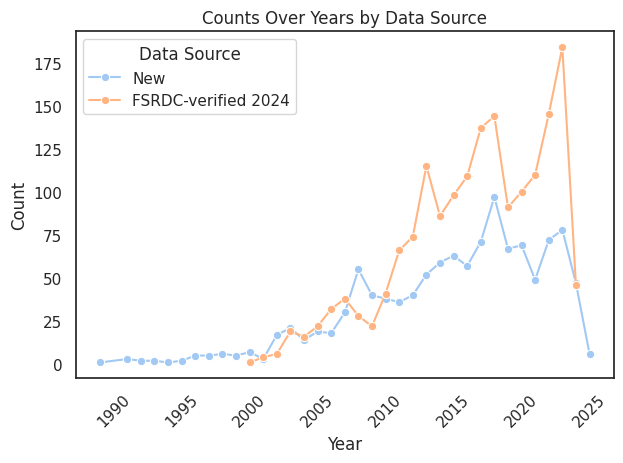

In [164]:
sns.set_style("white")
sns.lineplot(data=graph1_1, x='OutputYear', y='Count', hue='Data Source', marker='o')

# Add titles and labels
plt.title('Counts Over Years by Data Source')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [83]:
graph1_1[graph1_1["Data Source"] == "New" ].sort_values(by="Count", ascending=False)

,OutputYear,Data Source,Count
48,2018.0,New,97
58,2023.0,New,78
56,2022.0,New,72
46,2017.0,New,71
52,2020.0,New,69
50,2019.0,New,67
42,2015.0,New,63
40,2014.0,New,59
44,2016.0,New,57
28,2008.0,New,55


In [84]:
graph1_1.sort_values(by="OutputYear", ascending=False)

,OutputYear,Data Source,Count
61,2025.0,New,6
59,2024.0,FSRDC-verified 2024,46
60,2024.0,New,47
57,2023.0,FSRDC-verified 2024,184
58,2023.0,New,78
...,...,...,...
5,1994.0,New,1
4,1993.0,New,2
3,1992.0,New,2
2,1991.0,New,3


In [85]:
graph1_1[graph1_1["OutputYear"] == 2009]

,OutputYear,Data Source,Count
29,2009.0,FSRDC-verified 2024,22
30,2009.0,New,40


In [86]:
table1 = graph1.groupby(["Data Source", "OutputType_Clean"]).size().reset_index(name="Count")

In [87]:
table1 =table1.pivot(index="OutputType_Clean", columns="Data Source")

In [88]:
table1.head(n=3)

Count      
Data Source              FSRDC-verified 2024   New
OutputType_Clean                                  
Book                                    31.0  23.0
Dataset                                  1.0  13.0
Graduate Research Output                97.0   4.0

In [89]:
# remove the first level of labels
table1.columns = table1.columns.droplevel(0)


In [90]:
# replace NaN with 0
table1 = table1.fillna(0)


In [91]:
table1

Data Source,FSRDC-verified 2024,New
OutputType_Clean,,
Book,31.0,23.0
Dataset,1.0,13.0
Graduate Research Output,97.0,4.0
Journal Article Publication,495.0,1019.0
Other Publication,384.0,14.0
Software,4.0,0.0
Working Paper,717.0,80.0


In [92]:
table1["Percent-FSRDC-verified 2024"] = ((table1["FSRDC-verified 2024"])/(table1['FSRDC-verified 2024'].sum()))*100
table1["Percent-New"] = ((table1["New"])/(table1['New'].sum()))*100

In [93]:
table1["Difference"] = table1["Percent-New"] - table1["Percent-FSRDC-verified 2024"]

In [94]:
table1.loc[:,["Percent-FSRDC-verified 2024", "Percent-New", "Difference"]]

Data Source,Percent-FSRDC-verified 2024,Percent-New,Difference
OutputType_Clean,,,
Book,1.792944,1.994796,0.201852
Dataset,0.057837,1.127493,1.069657
Graduate Research Output,5.610179,0.346921,-5.263258
Journal Article Publication,28.629265,88.378144,59.748879
Other Publication,22.209370,1.214224,-20.995146
Software,0.231348,0.000000,-0.231348
Working Paper,41.469057,6.938422,-34.530636


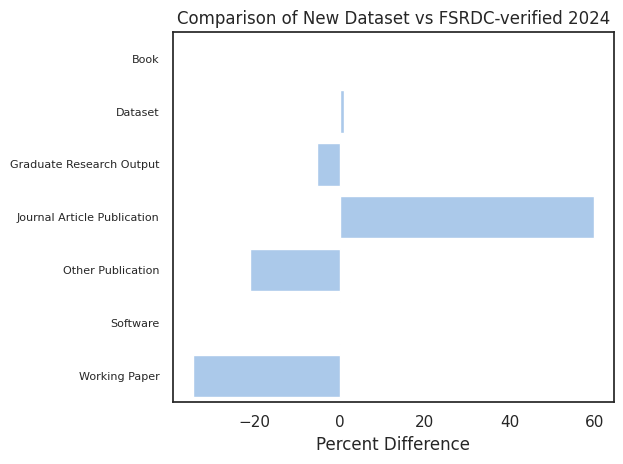

In [165]:
sns.set_style("white")

sns.barplot(data=table1, y='OutputType_Clean', x='Difference')

plt.xlabel("Percent Difference")
plt.ylabel("")
plt.title("Comparison of New Dataset vs FSRDC-verified 2024")
plt.yticks(fontsize=8)

plt.tight_layout()

plt.show()

In [96]:
table2_2 =graph1.groupby(["Data Source", "ProjectRDC", "OutputYear"]).size().reset_index(name="Count")

In [97]:
table2_2_new  = table2_2[table2_2["Data Source"]=="New"]

In [98]:
table2_2_new[table2_2_new['ProjectRDC'] == "UCLA"].sort_values(by="Count", ascending=False)

,Data Source,ProjectRDC,OutputYear,Count
641,New,UCLA,2008.0,29
640,New,UCLA,2007.0,13
643,New,UCLA,2010.0,5
642,New,UCLA,2009.0,5
648,New,UCLA,2015.0,4
647,New,UCLA,2014.0,4
651,New,UCLA,2020.0,3
646,New,UCLA,2013.0,3
645,New,UCLA,2012.0,2
637,New,UCLA,1997.0,1


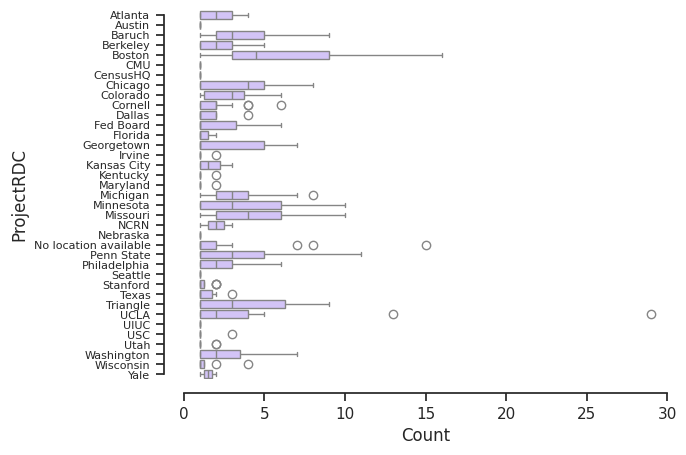

In [99]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x='Count', y='ProjectRDC', data=table2_2_new, color= "m")
sns.despine(offset=10, trim=True)
# Reduce the size of y-axis labels
plt.yticks(fontsize=8)  # Adjust the font size of the y-axis labels

# Show the plot
plt.show()

In [100]:
table2_2_old  = table2_2[table2_2["Data Source"]!="New"]

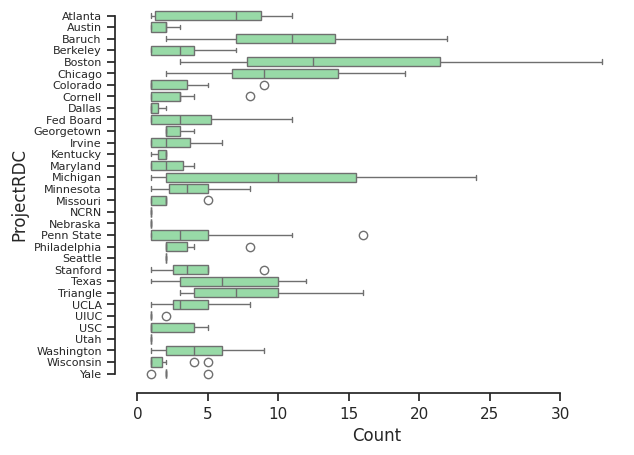

In [101]:
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(x='Count', y='ProjectRDC', data=table2_2_old, color= "g")
sns.despine(offset=10, trim=True)
# Reduce the size of y-axis labels
plt.yticks(fontsize=8)  # Adjust the font size of the y-axis labels

# Show the plot
plt.show()

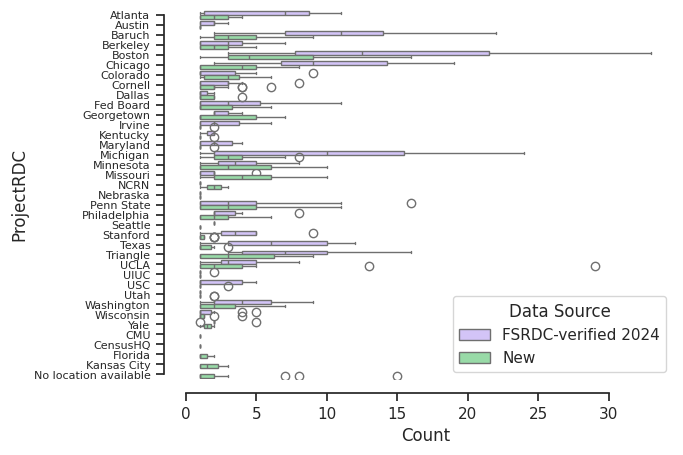

In [102]:
sns.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Count", y="ProjectRDC",
            hue="Data Source", palette=["m", "g"],
            data=table2_2)
sns.despine(offset=10, trim=True)
plt.yticks(fontsize=8)  # Adjust the font size of the y-axis labels

# Show the plot
plt.show()

# Analysis

## Topic Modelling

In [103]:
df_subset.head(n=3)
# replacing missing abstracts with titles
df_subset['Abstract'] = df_subset.apply(
    lambda row: row['OutputTitle'] if row['Abstract'] == "No abstract available" else row['Abstract'],
    axis=1)

In [104]:
# removing punctuation and stop words from abstract
df_subset['Abstract_clean'] = df_subset['Abstract'].apply(clean_text)
df_subset_1989 = df_subset[df_subset['OutputYear'] > 1988]

In [105]:
df_subset_1989.shape

(1157, 62)

In [106]:
# no need to tokenize
random_seed = 14678 # to esnure same topics identified

# Set UMAP's random state for reproducibility
umap_model = umap.UMAP(random_state=random_seed)

# Initialize the HDBSCAN
hdbscan_model = hdbscan.HDBSCAN()

# Initialize the BERTopic model with UMAP and HDBSCAN
model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, nr_topics=5)

topics, probs = model.fit_transform(df_subset_1989['Abstract_clean'])
# Add topics back to the DataFrame
df_subset_1989['Topic'] = topics

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [107]:
df_subset_1989['Topic'].value_counts()

,count
Topic,
0,680
1,246
-1,186
2,39
3,6


In [108]:
model.visualize_topics()

In [109]:
topics = model.get_topics()
# Display the top words for each topic
for topic, words in topics.items():
    print(f"Topic {topic}:")
    for word, weight in words:
        print(f"  {word}: {weight}")
    print()

Topic -1:
  data: 0.03627734517098306
  census: 0.033244448535356824
  us: 0.030007171460334582
  employment: 0.024455203510125065
  broadband: 0.02070909784142882
  using: 0.020415391603763787
  bureau: 0.018982022742330466
  business: 0.018751941088596864
  rural: 0.018011202200458286
  survey: 0.01725034324122647

Topic 0:
  data: 0.046749453305729695
  census: 0.033662902556278025
  survey: 0.02679073492957776
  using: 0.022125188271155255
  us: 0.021852121611844206
  american: 0.019962570160622292
  bureau: 0.01916770108947674
  couples: 0.01874765793576642
  community: 0.01812516299266777
  estimates: 0.016497941418023358

Topic 1:
  firms: 0.06477502236165034
  us: 0.04240437315361934
  data: 0.04109618370014056
  business: 0.03858143944468315
  firm: 0.03616722838431342
  census: 0.03017581559448967
  bureau: 0.026495343230061932
  productivity: 0.023845240064263272
  paper: 0.023625336906113507
  new: 0.02294813690692164

Topic 2:
  efficiency: 0.08487038390706371
  plants: 0.

In [110]:
df_subset_1989['OutputYear']

,OutputYear
0,2015.0
1,2019.0
2,2014.0
3,2014.0
4,2017.0
...,...
1153,1995.0
1154,2022.0
1155,2022.0
1156,2017.0


In [111]:
topics_over_time = model.topics_over_time(df_subset_1989['Abstract_clean'], df_subset_1989['OutputYear'],datetime_format= "%Y", nr_bins=36)

In [112]:
df_subset_1989["OutputYear"].value_counts().sort_index()

,count
OutputYear,
1989.0,1
1991.0,3
1992.0,2
1993.0,2
1994.0,1
1995.0,2
1996.0,5
1997.0,5
1998.0,6


In [113]:
topics_over_time['Timestamp'].value_counts()

,count
Timestamp,
2001.000,5
2007.000,4
2008.000,4
2004.000,4
2019.000,4
2016.000,4
2015.000,4
2014.000,4
2012.000,4


In [114]:
topics_over_time

,Topic,Words,Frequency,Timestamp
0,0,"redistribution, post1970, shifts, central, pat...",1,1988.964
1,-1,"gross, reallocation, job, employment, hoover",1,1990.000
2,0,"return, draft, lottery, education, veteran",1,1990.000
3,1,"asm, lrd, aggregates, estimates, data",1,1990.000
4,1,"business, manager, proxies, quality, discontin...",1,1991.000
...,...,...,...,...
108,1,"firms, share, highgrowth, innovation, us",11,2023.000
109,2,"uncertainty, challenge, flexible, negatively, ...",1,2023.000
110,-1,"arrangements, eviction, arrears, skipgeneratio...",2,2024.000
111,0,"data, census, ethnicity, changes, bureau",1,2024.000


In [115]:
custom_labels = {
    -1: "Rural Infrastructure & Employment Data",
    0: "Demographic Data & Household Structures",
    1: "Growth, Firm and Productivity",
    2: "Efficiency, Productivity and Economic Growth ",
    3: "Human Capital, Labor Force and Productivity"

}


In [116]:
topics_over_time['TopicsClean'] = topics_over_time['Topic'].map(custom_labels)


In [117]:
topics_over_time.head(n=10) # fractional format of date

,Topic,Words,Frequency,Timestamp,TopicsClean
0,0,"redistribution, post1970, shifts, central, pat...",1,1988.964,Demographic Data & Household Structures
1,-1,"gross, reallocation, job, employment, hoover",1,1990.000,Rural Infrastructure & Employment Data
2,0,"return, draft, lottery, education, veteran",1,1990.000,Demographic Data & Household Structures
3,1,"asm, lrd, aggregates, estimates, data",1,1990.000,"Growth, Firm and Productivity"
4,1,"business, manager, proxies, quality, discontin...",1,1991.000,"Growth, Firm and Productivity"
5,2,"energy, level, mecslrd, fourdigit, phase",1,1991.000,"Efficiency, Productivity and Economic Growth"
6,0,"housing, assistance, outcomes, assisted, house...",1,1992.000,Demographic Data & Household Structures
7,1,"performance, debt, buyouts, lbos, prelbo",1,1992.000,"Growth, Firm and Productivity"
8,1,"breakthroughs, shakeouts, breakthrough, indust...",1,1993.000,"Growth, Firm and Productivity"
9,0,"wage, market, skill, premium, power",1,1994.000,Demographic Data & Household Structures


In [118]:
table3 = topics_over_time.loc[:, ["Frequency", "Timestamp"]]
table3 = table3.groupby(["Timestamp"]).sum("Frequency")

In [119]:
table3= table3.rename(columns={"Frequency": "TotalCount"})
table3.head(n=3)

,TotalCount
Timestamp,
1988.964,1
1990.000,3
1991.000,2


In [120]:
# merge total count
table3 = pd.merge(topics_over_time, table3, on="Timestamp", how='left', indicator=True)
table3.head(n=3)

,Topic,Words,Frequency,Timestamp,TopicsClean,TotalCount,_merge
0,0,"redistribution, post1970, shifts, central, pat...",1,1988.964,Demographic Data & Household Structures,1,both
1,-1,"gross, reallocation, job, employment, hoover",1,1990.000,Rural Infrastructure & Employment Data,3,both
2,0,"return, draft, lottery, education, veteran",1,1990.000,Demographic Data & Household Structures,3,both


In [121]:
table3["Percent"] = (table3["Frequency"]/table3["TotalCount"])*100

In [122]:
table3.head(n=3)

,Topic,Words,Frequency,Timestamp,TopicsClean,TotalCount,_merge,Percent
0,0,"redistribution, post1970, shifts, central, pat...",1,1988.964,Demographic Data & Household Structures,1,both,100.000000
1,-1,"gross, reallocation, job, employment, hoover",1,1990.000,Rural Infrastructure & Employment Data,3,both,33.333333
2,0,"return, draft, lottery, education, veteran",1,1990.000,Demographic Data & Household Structures,3,both,33.333333


In [123]:
table3.sort_values(by="Timestamp", ascending=False)

,Topic,Words,Frequency,Timestamp,TopicsClean,TotalCount,_merge,Percent
111,0,"data, census, ethnicity, changes, bureau",1,2024.000,Demographic Data & Household Structures,6,both,16.666667
112,1,"employment, owner, financing, business, firmlevel",3,2024.000,"Growth, Firm and Productivity",6,both,50.000000
110,-1,"arrangements, eviction, arrears, skipgeneratio...",2,2024.000,Rural Infrastructure & Employment Data,6,both,33.333333
106,-1,"applications, likely, employers, census, us",9,2023.000,Rural Infrastructure & Employment Data,47,both,19.148936
107,0,"data, census, us, survey, using",26,2023.000,Demographic Data & Household Structures,47,both,55.319149
...,...,...,...,...,...,...,...,...
4,1,"business, manager, proxies, quality, discontin...",1,1991.000,"Growth, Firm and Productivity",2,both,50.000000
1,-1,"gross, reallocation, job, employment, hoover",1,1990.000,Rural Infrastructure & Employment Data,3,both,33.333333
3,1,"asm, lrd, aggregates, estimates, data",1,1990.000,"Growth, Firm and Productivity",3,both,33.333333
2,0,"return, draft, lottery, education, veteran",1,1990.000,Demographic Data & Household Structures,3,both,33.333333


In [124]:
table3[table3["Timestamp"] > 2007]

,Topic,Words,Frequency,Timestamp,TopicsClean,TotalCount,_merge,Percent
50,-1,"persons, uninsured, growth, rural, insurance",10,2008.0,Rural Infrastructure & Employment Data,40,both,25.000000
51,0,"data, census, disability, survey, using",18,2008.0,Demographic Data & Household Structures,40,both,45.000000
52,1,"firms, us, business, segment, reporting",9,2008.0,"Growth, Firm and Productivity",40,both,22.500000
53,2,"efficiency, firms, vc, plants, vcbacked",3,2008.0,"Efficiency, Productivity and Economic Growth",40,both,7.500000
54,-1,"neighborhood, perceptions, microneighbourhood,...",5,2009.0,Rural Infrastructure & Employment Data,38,both,13.157895
...,...,...,...,...,...,...,...,...
108,1,"firms, share, highgrowth, innovation, us",11,2023.0,"Growth, Firm and Productivity",47,both,23.404255
109,2,"uncertainty, challenge, flexible, negatively, ...",1,2023.0,"Efficiency, Productivity and Economic Growth",47,both,2.127660
110,-1,"arrangements, eviction, arrears, skipgeneratio...",2,2024.0,Rural Infrastructure & Employment Data,6,both,33.333333
111,0,"data, census, ethnicity, changes, bureau",1,2024.0,Demographic Data & Household Structures,6,both,16.666667


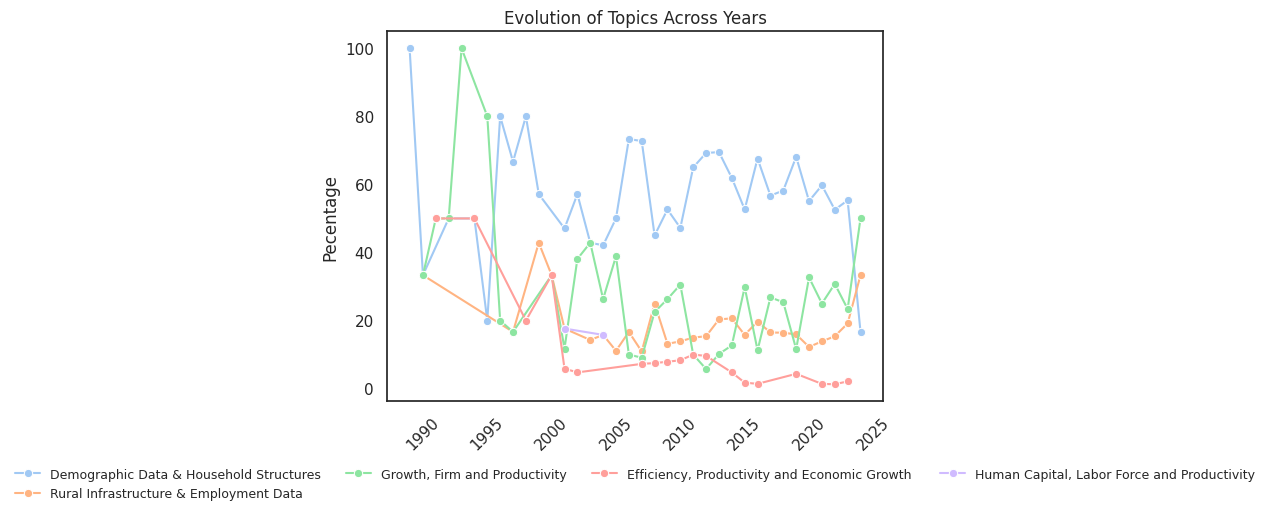

In [125]:
sns.set_style("white")
sns.lineplot(data=table3, x='Timestamp', y='Percent', hue='TopicsClean', marker='o')

# Add titles and labels
plt.title('Evolution of Topics Across Years')
plt.xlabel('')
plt.ylabel('Pecentage')
plt.xticks(rotation=45)
plt.legend(
    title='',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=4,  # number of columns in the legend
    prop={'size': 9},
    frameon=False
)

#plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 7})

plt.tight_layout()
plt.show()



In [126]:
df_subset_1989.head(n=3)

,OutputTitle,year,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_45,Author_46,Author_47,Author_48,OutputType_Clean,Data Source,PublicationDate_clean,OutputYear,Abstract_clean,Topic
0,The Bridge between the LexisNexis Directory of...,2015,2015-01-01,"{Yue Maggie Zhou, Aaron Flaaen}",The purpose of this matching exercise is to co...,Cooperative Studies and Economics,article,Michigan,0.0,Aaron Flaaen,...,None,None,None,None,Journal Article Publication,New,2015-01-01,2015.0,purpose matching exercise construct concordanc...,1
1,Vulnerable Jobs and the Wage Effects of Import...,2019,2019-06-10,"{Abigail M. Cooke, David L. Rigby, Thomas Kemeny}",Do job characteristics modulate the relationsh...,Employment and Welfare Studies; Labor market d...,article,Triangle,1.0,Abigail M. Cooke,...,None,None,None,None,Journal Article Publication,New,2019-06-10,2019.0,job characteristics modulate relationship impo...,1
2,Impacts of Trade on Wage Inequality across the...,2014,2014-01-01,{Abigail M. Cooke},The research presented in this dissertation ex...,Regional Economic and Spatial Analysis,article,Triangle,0.0,Abigail M. Cooke,...,None,None,None,None,Journal Article Publication,New,2014-01-01,2014.0,research presented dissertation examines impac...,-1


In [127]:
test= df_subset_1989.groupby(["OutputYear", "Topic"]).agg({'CiteCount': ['sum']}).reset_index()
test.columns = test.columns.droplevel(1)
test['TopicsClean'] = test['Topic'].map(custom_labels)


In [128]:
df_subset_1989[df_subset_1989["OutputYear"] == 2024]

,OutputTitle,year,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_45,Author_46,Author_47,Author_48,OutputType_Clean,Data Source,PublicationDate_clean,OutputYear,Abstract_clean,Topic
79,State and Local Government Expenditures and In...,2024,2024-11-06,"{Ashley H. Hirai, Shivani J. Sowmyan, Jay S. K...",OBJECTIVES A previous study reported that incr...,Health disparities and outcomes; Global Health...,article,Colorado,1.0,Ashley H. Hirai,...,None,None,None,None,Journal Article Publication,New,2024-11-06,2024.0,OBJECTIVES previous study reported increased s...,0
113,"Achieving the American Dream, Homeownership We...",2024,2024-01-01,{Brooks Depro},Since adopting the all-volunteer force in 1973...,Political and Economic history of UK and US,article,Triangle,0.0,Brooks Depro,...,None,None,None,None,Journal Article Publication,New,2024-01-01,2024.0,"Since adopting all-volunteer force 1973, many ...",0
131,The Mental Health Consequences of George Floyd...,2024,2024-09-13,"{Christopher Uggen, Ryan Larson, N. Jeanie San...",The high-profile police murder of George Floyd...,"Homelessness and Social Issues; Race, History,...",article,Minnesota,1.0,Christopher Robertson,...,None,None,None,None,Journal Article Publication,New,2024-09-13,2024.0,high-profile police murder George Floyd likely...,0
151,Does ethnoracial context diversity predict imp...,2024,2024-12-09,"{Cody Spence, Mehrgol Tiv}",We examined whether exposure to context divers...,Social and Intergroup Psychology; Racial and E...,article,Missouri,0.0,Cody Spence,...,None,None,None,None,Journal Article Publication,New,2024-12-09,2024.0,examined whether exposure context diversity on...,0
160,Comparisons of administrative record rosters t...,2024,2024-02-01,"{Vincent T. Mule, Mary H. Mulry, Andrew Keller...",One of the U.S. Census Bureau’s innovations in...,Census and Population Estimation; Data Quality...,article,Boston,0.0,Andrew Keller,...,None,None,None,None,Journal Article Publication,New,2024-02-01,2024.0,One U.S. Census Bureau’s innovations 2020 U.S....,0
202,Linking national primary care electronic healt...,2024,2024-11-08,"{Robert L. Phillips, Victoria Udalova, David H...",To evaluate the likelihood of linking electron...,Primary Care and Health Outcomes; Healthcare P...,article,Minnesota,0.0,Aubrey Limburg,...,None,None,None,None,Journal Article Publication,New,2024-11-08,2024.0,evaluate likelihood linking electronic health ...,-1
209,"Optimized spatial information for 1990, 2000, ...",2024,2024-01-05,"{Jonathan Schroeder, Christopher S. Fowler, Da...",We report on the successful completion of a pr...,Human Mobility and Location-Based Analysis; Im...,article,Minnesota,0.0,Christopher S. Fowler,...,None,None,None,None,Journal Article Publication,New,2024-01-05,2024.0,report successful completion project upgrade p...,-1
251,Business Applications as a Leading Economic In...,2024,2024-12-01,"{Emin Dinlersoz, Alyson Plumb, Jose Asturias, ...",How are applications to start new businesses r...,NaN,report,Berkeley,0.0,Alyson Plumb,...,None,None,None,None,Working Paper,New,2024-12-01,2024.0,applications start new businesses related aggr...,-1
278,Measuring the Flow-Down of Injury Risks Along ...,2024,2024-01-01,"{Kevin Conner, Jeff Waddoups, Kevin Duncan, Pe...",Construction workers experience high rates of ...,Occupational Health and Safety Research; Risk ...,preprint,Utah,0.0,Frederick Purifoy,...,None,None,None,None,Journal Article Publication,New,2024-01-01,2024.0,Construction workers experience high rates inj...,0
392,2020 Klein Lecture—Investment and Subjective U...,2024,2024-05-21,"{Steven J. Davis, Lucia Foster, Scott Ohlmache...",Abstract A longstanding challenge in evaluatin...,Market Dynamics and Volatility; Climate Change...,article,Michigan,2.0,Itay Saporta‐Eksten,...,None,None,None,None,Journal Article Publication,New,2024-05-21,2024.0,Abstract longstanding challenge evaluating imp...,2


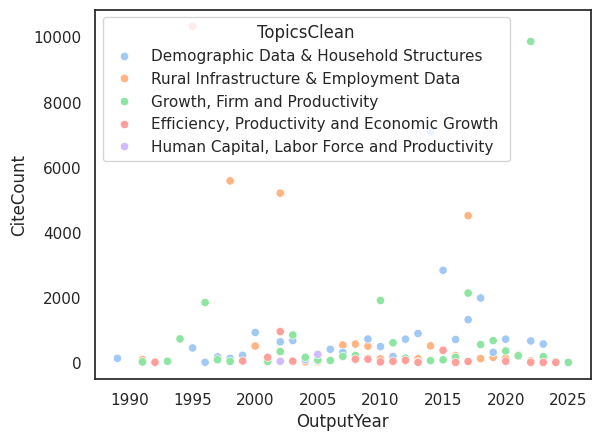

In [129]:
# Create the scatter plot, coloring by topic
sns.scatterplot(x='OutputYear', y='CiteCount', hue='TopicsClean', data=test)
# Show the plot
plt.show() #

<Axes: xlabel='CiteCount', ylabel='TopicsClean'>

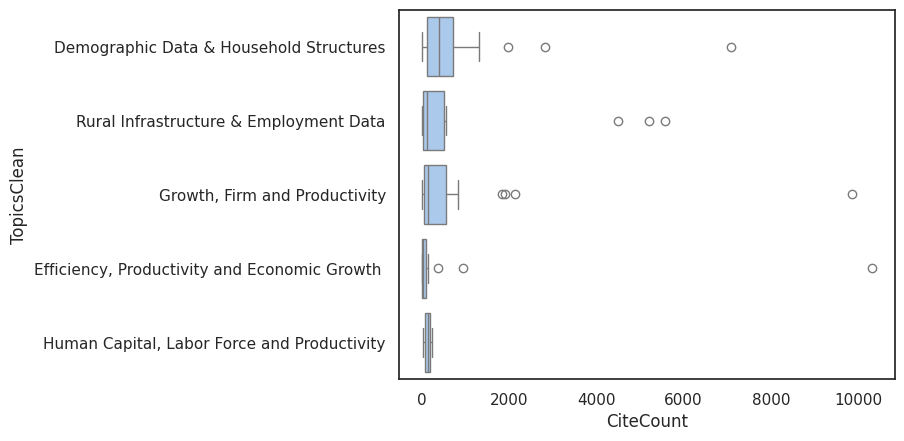

In [130]:
sns.set_style("white")

sns.boxplot(x='CiteCount', y='TopicsClean', data=test)

In [131]:
test[test["CiteCount"] > 9000]

,OutputYear,Topic,CiteCount,TopicsClean
10,1995.0,2,10328.0,"Efficiency, Productivity and Economic Growth"
100,2022.0,1,9866.0,"Growth, Firm and Productivity"


## Multivariate Regression Analysis

In [132]:
df_subset_1989['TopicsClean'] = df_subset_1989['Topic'].map(custom_labels)


In [133]:
df_subset_1989.head(n=3)

,OutputTitle,year,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_46,Author_47,Author_48,OutputType_Clean,Data Source,PublicationDate_clean,OutputYear,Abstract_clean,Topic,TopicsClean
0,The Bridge between the LexisNexis Directory of...,2015,2015-01-01,"{Yue Maggie Zhou, Aaron Flaaen}",The purpose of this matching exercise is to co...,Cooperative Studies and Economics,article,Michigan,0.0,Aaron Flaaen,...,None,None,None,Journal Article Publication,New,2015-01-01,2015.0,purpose matching exercise construct concordanc...,1,"Growth, Firm and Productivity"
1,Vulnerable Jobs and the Wage Effects of Import...,2019,2019-06-10,"{Abigail M. Cooke, David L. Rigby, Thomas Kemeny}",Do job characteristics modulate the relationsh...,Employment and Welfare Studies; Labor market d...,article,Triangle,1.0,Abigail M. Cooke,...,None,None,None,Journal Article Publication,New,2019-06-10,2019.0,job characteristics modulate relationship impo...,1,"Growth, Firm and Productivity"
2,Impacts of Trade on Wage Inequality across the...,2014,2014-01-01,{Abigail M. Cooke},The research presented in this dissertation ex...,Regional Economic and Spatial Analysis,article,Triangle,0.0,Abigail M. Cooke,...,None,None,None,Journal Article Publication,New,2014-01-01,2014.0,research presented dissertation examines impac...,-1,Rural Infrastructure & Employment Data


In [134]:
df_subset_1989['PublicationDate'] = pd.to_datetime(df_subset_1989['PublicationDate'])
# Specify reference date
reference_date = pd.Timestamp('2025-03-30')
# Calculate days since publication
df_subset_1989['days_since_publication'] = (reference_date - df_subset_1989['PublicationDate']).dt.days


In [135]:
print(df_subset_1989.isnull().sum())

OutputTitle               3
year                      0
PublicationDate           5
ProjectPI                 0
Abstract                  0
                         ..
OutputYear                0
Abstract_clean            0
Topic                     0
TopicsClean               0
days_since_publication    5
Length: 65, dtype: int64


In [136]:
df_subset_1989.head(n=3)

,OutputTitle,year,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_47,Author_48,OutputType_Clean,Data Source,PublicationDate_clean,OutputYear,Abstract_clean,Topic,TopicsClean,days_since_publication
0,The Bridge between the LexisNexis Directory of...,2015,2015-01-01,"{Yue Maggie Zhou, Aaron Flaaen}",The purpose of this matching exercise is to co...,Cooperative Studies and Economics,article,Michigan,0.0,Aaron Flaaen,...,None,None,Journal Article Publication,New,2015-01-01,2015.0,purpose matching exercise construct concordanc...,1,"Growth, Firm and Productivity",3741.0
1,Vulnerable Jobs and the Wage Effects of Import...,2019,2019-06-10,"{Abigail M. Cooke, David L. Rigby, Thomas Kemeny}",Do job characteristics modulate the relationsh...,Employment and Welfare Studies; Labor market d...,article,Triangle,1.0,Abigail M. Cooke,...,None,None,Journal Article Publication,New,2019-06-10,2019.0,job characteristics modulate relationship impo...,1,"Growth, Firm and Productivity",2120.0
2,Impacts of Trade on Wage Inequality across the...,2014,2014-01-01,{Abigail M. Cooke},The research presented in this dissertation ex...,Regional Economic and Spatial Analysis,article,Triangle,0.0,Abigail M. Cooke,...,None,None,Journal Article Publication,New,2014-01-01,2014.0,research presented dissertation examines impac...,-1,Rural Infrastructure & Employment Data,4106.0


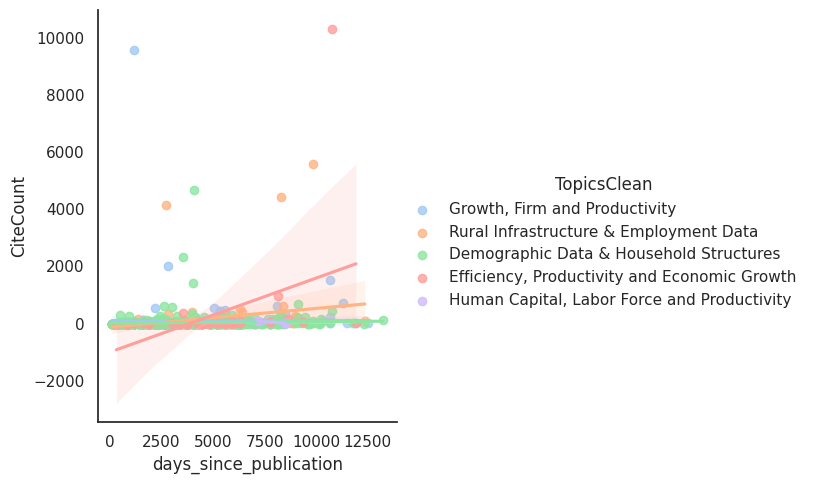

In [137]:
sns.lmplot(x='days_since_publication', y='CiteCount', data=df_subset_1989, hue='TopicsClean')
plt.show()

In [138]:
model_ols = smf.ols('CiteCount ~ days_since_publication+C(TopicsClean)+days_since_publication*C(TopicsClean)', data=df_subset_1989).fit()

print(model_ols.summary())


                            OLS Regression Results                            
Dep. Variable:              CiteCount   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           4.01e-16
Time:                        00:41:45   Log-Likelihood:                -8780.3
No. Observations:                1152   AIC:                         1.758e+04
Df Residuals:                    1142   BIC:                         1.763e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

# Additional Analysis: Network

In [139]:
class ResearchOutput:
  """
  Create object ResearchOutput storing title, year, agency and topics
  Defines equality cases for testing purposes
  """
  def __init__(self, title, year, agency, topics, keyword, author):  # constructor
    self.title = title
    self.year = year
    self.agency = agency
    self.topics = topics
    self.keyword = keyword
    self.author = author

  def __repr__(self):
    return f"ResearchOutput({self.title},{self.year})"

  def __eq__(self, other): # important for unit testing later
    if isinstance(other, ResearchOutput):
      return self.title == other.title and self.year == other.year and self.keyword == self.keyword and self.agency == self.agency and self.author == self.author # Compare the title and year attributes for equality
    return False
  def __hash__(self):
    return hash((self.title, self.year)) # this is imp as we want use them as dictionary keys later

outputs = [] # initialize empty list
for index, row in df_subset_1989.iterrows():
  output = ResearchOutput(row['OutputTitle'], row['OutputYear'], row['ProjectRDC'],row['TopicsClean'],  row['Keywords'], row['ProjectPI']) # using class defined earlier
  outputs.append(output) # add to list

def shareCommonAttribute(r1, r2):
    """
    Function to identify links between research outputs
    Args: two research output objects
    Returns: True if research outputs share common attributes, False otherwise
    """
    if r1.agency.lower() == r2.agency.lower() and r1.topics.lower() == r2.topics.lower(): # check link between agency
        return True
    return False # if no common attributes are found, return False

def create_graph(name_dataset):
  """
  Function to create graph linking research outputs with common agency/keyword
  Args: name of list with each research output stored  as object
  Returns: dict object with nodes as key and edges as values
  """
  G = {} # intialize graph as empty dictionary
  for r in name_dataset:
    G[r] = [] # empty list for values for nodes
  for i in range(len(name_dataset)): # start loop begining from first item
    for j in range(i + 1, len(name_dataset)): # starting from second item
      r1 = name_dataset[i] # storing the info for 1 element
      r2 = name_dataset[j] # storing the info for 2 element
      if shareCommonAttribute(r1,r2): # identifying if they have any common agency/keyword
        G[r1].append(r2)  # adding links
        G[r2].append(r1)  # adding links
  return G

G = create_graph(outputs)
len(G)

918

In [143]:
# Check unique outputs i.e. outputs with different titles, keywords and years
unique_outputs = set() # initalize empty set
for r in outputs:
  unique_outputs.add(r) # add items to set

print(f"The dataset contains {len(unique_outputs)} unique research outputs i.e. title, year, agency, topics, keyword, author.")



The dataset contains 918 unique research outputs i.e. title, year, agency, topics, keyword, author.


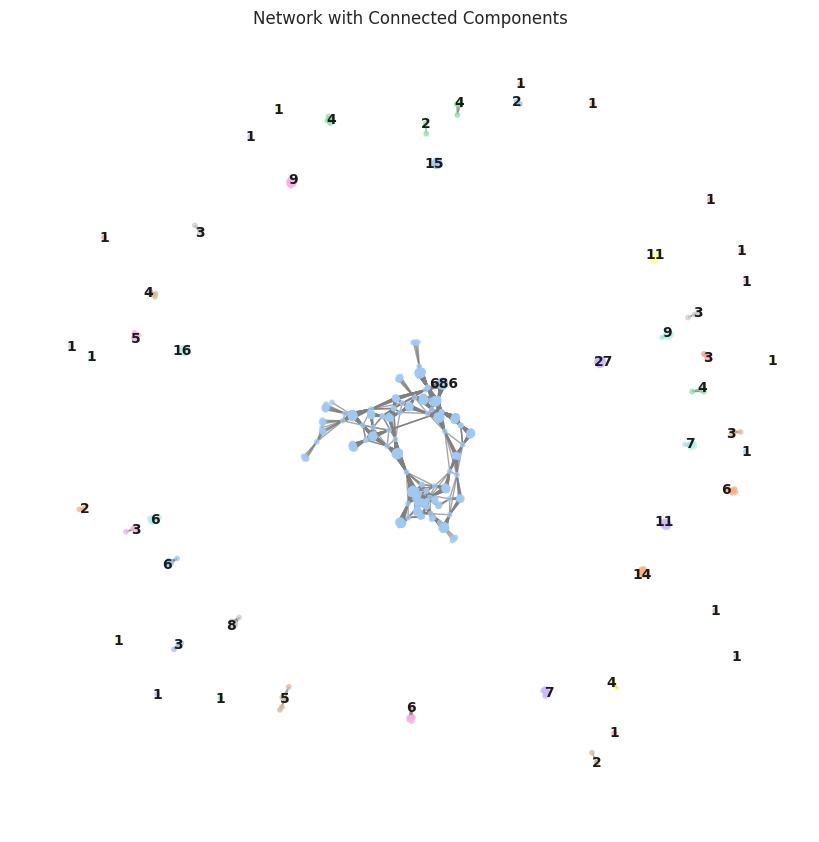

Connected components:
Component 1: {ResearchOutput(Demographics of Married and Unmarried Same-sex Couples: Analyses of the 2013 American Community Survey,2015.0), ResearchOutput(Transgender Military Service in the United States,2014.0), ResearchOutput(Railroads, Reallocation, and the Rise of American Manufacturing,2019.0), ResearchOutput(The Spatial Extent of Agglomeration Economies: Evidence from Three U.S. Manufacturing Industries,2012.0), ResearchOutput(Multinational Firms in the U.S. Economy: Insights from Newly Integrated Microdata,2010.0), ResearchOutput(Block, Tract, and Levels of Aggregation: Neighborhood Structure and Crime and Disorder as a Case in Point,2007.0), ResearchOutput(Application of Experimental Poverty Measures to the Aged,1999.0), ResearchOutput(An Anatomy of U.S. Firms Seeking Trademark Registration,2018.0), ResearchOutput(Dutch Disease or Agglomeration? The Local Economic Effects of Natural Resource Booms in Modern America,2017.0), ResearchOutput(New Census Bure

In [144]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Create the graph
graph = nx.Graph()
for node in G.keys():
    graph.add_node(node)

# Step 2: Add edges from the dictionary
for node, neighbors in G.items():
    for neighbor in neighbors:
        graph.add_edge(node, neighbor)

# Step 3: Find connected components
connected_components = list(nx.connected_components(graph))

# Step 3: Identify connected components
components = list(nx.connected_components(graph))

# Step 4: Create a dictionary of labels where the key is the node and the value is the component size
labels_to_display = {}
for component in components:
    component_size = len(component)  # Size of the current component
    # Choose a representative node from the component (e.g., first node)
    representative_node = next(iter(component))
    labels_to_display[representative_node] = str(component_size)

# Step 4: Assign colors to nodes based on connected components
node_colors = []
for node in graph.nodes():
    for idx, component in enumerate(connected_components):
        if node in component:
            node_colors.append(f"C{idx}")  # Color by component index

graph.remove_edges_from(nx.selfloop_edges(graph))

# Step 5: Visualize the graph with nodes colored by connected component
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)  # Positions for the nodes

# Draw the graph with different colors for different components
nx.draw(graph, pos, with_labels=False, node_size=10, node_color=node_colors, font_size=10, font_weight='bold', edge_color="gray", alpha=0.7)
nx.draw_networkx_labels(graph, pos, labels=labels_to_display, font_size=10, font_weight='bold')

# Title and show the plot
plt.title("Network with Connected Components")
plt.show()

# Optional: Print the connected components
print("Connected components:")
for idx, component in enumerate(connected_components):
    print(f"Component {idx + 1}: {component}")


In [145]:
print(f"Number of nodes: {graph.number_of_nodes()}")
print(f"Number of edges: {graph.number_of_edges()}")

Number of nodes: 918
Number of edges: 13635


In [146]:
labels_to_display

{ResearchOutput(Demographics of Married and Unmarried Same-sex Couples: Analyses of the 2013 American Community Survey,2015.0): '686',
 ResearchOutput(Comparing Methods for Imputing Employer Health Insurance Contributions in the Current Population Survey,2013.0): '6',
 ResearchOutput(Current and Future Demographics of the Veteran Population, 2014–2024,2018.0): '4',
 ResearchOutput(Job-to-Job (J2J) Flows: New Labor Market Statistics from Linked Employer-Employee Data,2014.0): '3',
 ResearchOutput(Evaluation of Selective Editing for the US Census Bureau Foreign Trade Data 1,2013.0): '1',
 ResearchOutput(Development of a multidimensional housing and environmental quality index (HEQI): application to the American Housing Survey,2022.0): '3',
 ResearchOutput(Influence of Relative Age Effects upon Earning the PhD,2013.0): '9',
 ResearchOutput(Busy Businesses and Busy Contexts: The Distribution and Sources of Crime at Commercial Properties,2019.0): '3',
 ResearchOutput(Small-area estimates fr

In [147]:
df_subset_1989[df_subset_1989["OutputTitle"] == "Comparisons of administrative record rosters to census self-responses and NRFU household member responses1"]

,OutputTitle,year,PublicationDate,ProjectPI,Abstract,Keywords,OutputType,ProjectRDC,CiteCount,Author_1,...,Author_47,Author_48,OutputType_Clean,Data Source,PublicationDate_clean,OutputYear,Abstract_clean,Topic,TopicsClean,days_since_publication
160,Comparisons of administrative record rosters t...,2024,2024-02-01,"{Vincent T. Mule, Mary H. Mulry, Andrew Keller...",One of the U.S. Census Bureau’s innovations in...,Census and Population Estimation; Data Quality...,article,Boston,0.0,Andrew Keller,...,None,None,Journal Article Publication,New,2024-02-01,2024.0,One U.S. Census Bureau’s innovations 2020 U.S....,0,Demographic Data & Household Structures,423.0


In [148]:
df_subset_bos = df_subset_1989[df_subset_1989["ProjectRDC"] == "Boston"]
df_subset_bos= df_subset_bos[df_subset_bos["TopicsClean"] == "Demographic Data & Household Structures"]

In [149]:
df_subset_bos["CiteCount"].mean()

np.float64(26.074626865671643)

# Testing

## Testing Functions


### Processing and Cleaning

In [152]:
data_test = {
    'name': ['Alice', 'Bob', 'Charlie'],
    'age': [25, 30, 35],
    'city': ['New York', 'Los Angeles', 'Chicago']
}

data_test = pd.DataFrame(data_test)

data_test.to_csv('sample_data_file.csv', index=False)

In [153]:
load_data("imaginary.csv")

File not found. Check file path.


In [154]:
test2 = load_data("sample_data_file.csv")

In [155]:
# dataset processing function
assert data_test.equals(test2)

In [156]:
# text cleaning
assert clean_text("I am a cocunut") == 'cocunut' # removing stop words
assert clean_text("I am a") == '' # all stop words

assert clean_text("I am the queen of the world") == 'queen world' # sandwiched stop words


### Graph

In [157]:
outputs = [] # initialize empty list
for index, row in df_subset_1989.iterrows():
  output = ResearchOutput(row['OutputTitle'], row['OutputYear'], row['ProjectRDC'],row['TopicsClean'],  row['Keywords'], row['ProjectPI']) # using class defined earlier
  outputs.append(output) # add to list


In [158]:
df_subset_1989.loc[:,['OutputTitle','OutputYear','ProjectRDC','TopicsClean','Keywords','ProjectPI']].head(n=3)

,OutputTitle,OutputYear,ProjectRDC,TopicsClean,Keywords,ProjectPI
0,The Bridge between the LexisNexis Directory of...,2015.0,Michigan,"Growth, Firm and Productivity",Cooperative Studies and Economics,"{Yue Maggie Zhou, Aaron Flaaen}"
1,Vulnerable Jobs and the Wage Effects of Import...,2019.0,Triangle,"Growth, Firm and Productivity",Employment and Welfare Studies; Labor market d...,"{Abigail M. Cooke, David L. Rigby, Thomas Kemeny}"
2,Impacts of Trade on Wage Inequality across the...,2014.0,Triangle,Rural Infrastructure & Employment Data,Regional Economic and Spatial Analysis,{Abigail M. Cooke}


In [159]:
# Test 1: Only link is rdc
research_outputs_test1 = [ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"),
                          ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"),
                          ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "Boston", "Firm Growth","technology; innovation; exports",  "{D. Stigler Joseph}")]

# Test 2: Only link is topic
research_outputs_test2 = [ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"),
                          ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"),
                          ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "UCLA", "Economic Growth","technology; innovation; exports",  "{D. Stigler Joseph}")]

# Test 3: No Link
research_outputs_test3 = [ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"),
                          ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"),
                          ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "UCLA", "Firm Growth","technology; innovation; exports",  "{D. Stigler Joseph}")]


# Test 4: Both linked
research_outputs_test4 = [ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"),
                          ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"),
                          ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "Boston", "Gender and Growth","technology; innovation; exports",  "{D. Stigler Joseph}")]


In [160]:
# Using Test 1: Only link is rdc
graph_result1= {ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"): [],
  ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"): [],
 ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "Boston", "Firm Growth","technology; innovation; exports",  "{D. Stigler Joseph}"): []}



# Using Test 2:

graph_result2= {ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"): [],
  ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"): [],
 ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "UCLA", "Economic Growth","technology; innovation; exports",  "{D. Stigler Joseph}"): []}


# Using Test 3

graph_result3= {ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"): [],
  ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"): [],
 ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "UCLA", "Firm Growth","technology; innovation; exports",  "{D. Stigler Joseph}"): []}

# Using Test 4:

graph_result4= {ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}"): [ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "Boston", "Gender and Growth","technology; innovation; exports",  "{D. Stigler Joseph}")],
  ResearchOutput("The Role of Trade Liberalization in Economic Growth", "2005", "Michigan", "Economic Growth", "Employment and Welfare Studies", "{Aaron Stromer}"): [],
 ResearchOutput("Technological Innovation and Export Competitiveness", "2006", "Boston", "Gender and Growth","technology; innovation; exports",  "{D. Stigler Joseph}"): [ResearchOutput("Labor Market Returns", "2002", "Boston", "Gender and Growth", "Cooperative Studies and Economics", "{Aaron Flaaen, Yue Maggie Zhou}")]}



In [161]:
research_outputs_test1[2]

ResearchOutput(Technological Innovation and Export Competitiveness,2006)

In [162]:
class TestGraph(unittest.TestCase):

    def test_shareCommonAttribute(self):
        '''Test case function for shareCommonAttributes'''
        result = []
        result.append(shareCommonAttribute(research_outputs_test1[0],research_outputs_test1[1]))
        result.append(shareCommonAttribute(research_outputs_test1[0],research_outputs_test1[2]))
        result.append(shareCommonAttribute(research_outputs_test4[0],research_outputs_test4[2]))
        expected = [False, False, True]
        self.assertEqual(result, expected)
    def test_create_graph_1(self):
        '''Test case function for graph: with Test Case 1 '''
        result = create_graph(research_outputs_test1)
        expected = graph_result1
        self.assertEqual(result, expected)
    def test_create_graph_2(self):
        '''Test case function for graph: with Test Case 2 '''
        result = create_graph(research_outputs_test2)
        expected = graph_result2
        self.assertEqual(result, expected)
    def test_create_graph_3(self):
        '''Test case function for graph: with Test Case 3  '''
        result = create_graph(research_outputs_test3)
        expected = graph_result3
        self.assertEqual(result, expected)

    def test_create_graph_4(self):
        '''Test case function for graph: with Test Case 4 '''
        result = create_graph(research_outputs_test4)
        expected = graph_result4
        self.assertEqual(result, expected)


In [163]:
if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)

test_create_graph_1 (__main__.TestGraph.test_create_graph_1)
Test case function for graph: with Test Case 1 ... ok
test_create_graph_2 (__main__.TestGraph.test_create_graph_2)
Test case function for graph: with Test Case 2 ... ok
test_create_graph_3 (__main__.TestGraph.test_create_graph_3)
Test case function for graph: with Test Case 3 ... ok
test_create_graph_4 (__main__.TestGraph.test_create_graph_4)
Test case function for graph: with Test Case 4 ... ok
test_shareCommonAttribute (__main__.TestGraph.test_shareCommonAttribute)
Test case function for shareCommonAttributes ... ok

----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK
